In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine
from datetime import date
import matplotlib.dates as mdates
import calendar
from matplotlib.ticker import FuncFormatter, PercentFormatter

sns.set_style("darkgrid")
sns.set(font_scale=1.5)
%matplotlib inline

In [2]:
def get_new_york_metro_monthly_stats():
    """ Return a dataframe flight counts by day of week and year  """
    engine = create_engine('sqlite:///./../../data/processed/airlines.db')
    
    with engine.connect() as conn:
        flights = pd.read_sql("""
            SELECT 
                f.origin as Airport,
                f.year as year,
                f.month as month,
                1 as day,
                SUM(f.flights) AS departures,
                SUM(f.departure_was_delayed_15) AS delays
            FROM 
                flights AS f
            WHERE 
                f.year in (2013, 2014, 2015, 2016, 2017)
            AND 
                f.origin in ('EWR', 'JFK', 'LGA')
            GROUP BY 
                f.origin, f.year, f.month
            ORDER BY
                f.origin, f.year, f.month ASC
        """, conn)
        
        # Create datetime stamp, sort values, caculate the percentage of flights that were delayed
        flights['date'] = pd.to_datetime(flights[['year','month','day']])
        flights = flights.sort_values(['Airport', 'date'])
        flights['delay_rate'] = flights['delays'] / flights['departures']
        flights['month_abbr'] = flights['month'].apply(lambda x: calendar.month_abbr[x])
        
    return flights

# Get summary data for selected date range, counting flights delayed more than 15 minutes on departure
ny_metro = get_new_york_metro_monthly_stats()
ny_metro.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 180 entries, 0 to 179
Data columns (total 9 columns):
Airport       180 non-null object
year          180 non-null int64
month         180 non-null int64
day           180 non-null int64
departures    180 non-null int64
delays        180 non-null int64
date          180 non-null datetime64[ns]
delay_rate    180 non-null float64
month_abbr    180 non-null object
dtypes: datetime64[ns](1), float64(1), int64(5), object(2)
memory usage: 14.1+ KB


In [3]:
def plot_ny_metro_comparison(flights, y_value='departures', y_formatter=None, y_label="", title=""):

    fig, ax = plt.subplots(figsize=(15, 5), dpi=240)
    
    EWR = flights[flights['Airport'] == 'EWR'].set_index('date')
    LGA = flights[flights['Airport'] == 'LGA'].set_index('date')
    JFK = flights[flights['Airport'] == 'JFK'].set_index('date')
    
    _ = ax.plot(EWR.index, EWR[y_value], linewidth=2, markevery=3, color='red')
    _ = ax.plot(LGA.index, LGA[y_value], linewidth=2, markevery=3, color='blue')
    _ = ax.plot(JFK.index, JFK[y_value], linewidth=2, markevery=3, color='green')

    quarter = mdates.MonthLocator(interval=3)  # quarterly
    months = mdates.MonthLocator()  # every month
    monthFmt = mdates.DateFormatter("%b '%y")

    # format the xticks
    _ = ax.xaxis.set_major_locator(quarter)
    _ = ax.xaxis.set_major_formatter(monthFmt)
    _ = plt.xticks(rotation=75)

    # format y ticks
    _ = ax.yaxis.set_major_locator(plt.AutoLocator())
    _ = ax.yaxis.set_major_formatter(y_formatter)
    

    # Set the limits
    _ = ax.set_xlim(EWR.index.min(), EWR.index.max())

    _ = plt.ylabel(y_label)
    _ = plt.title(title)

    plt.show()

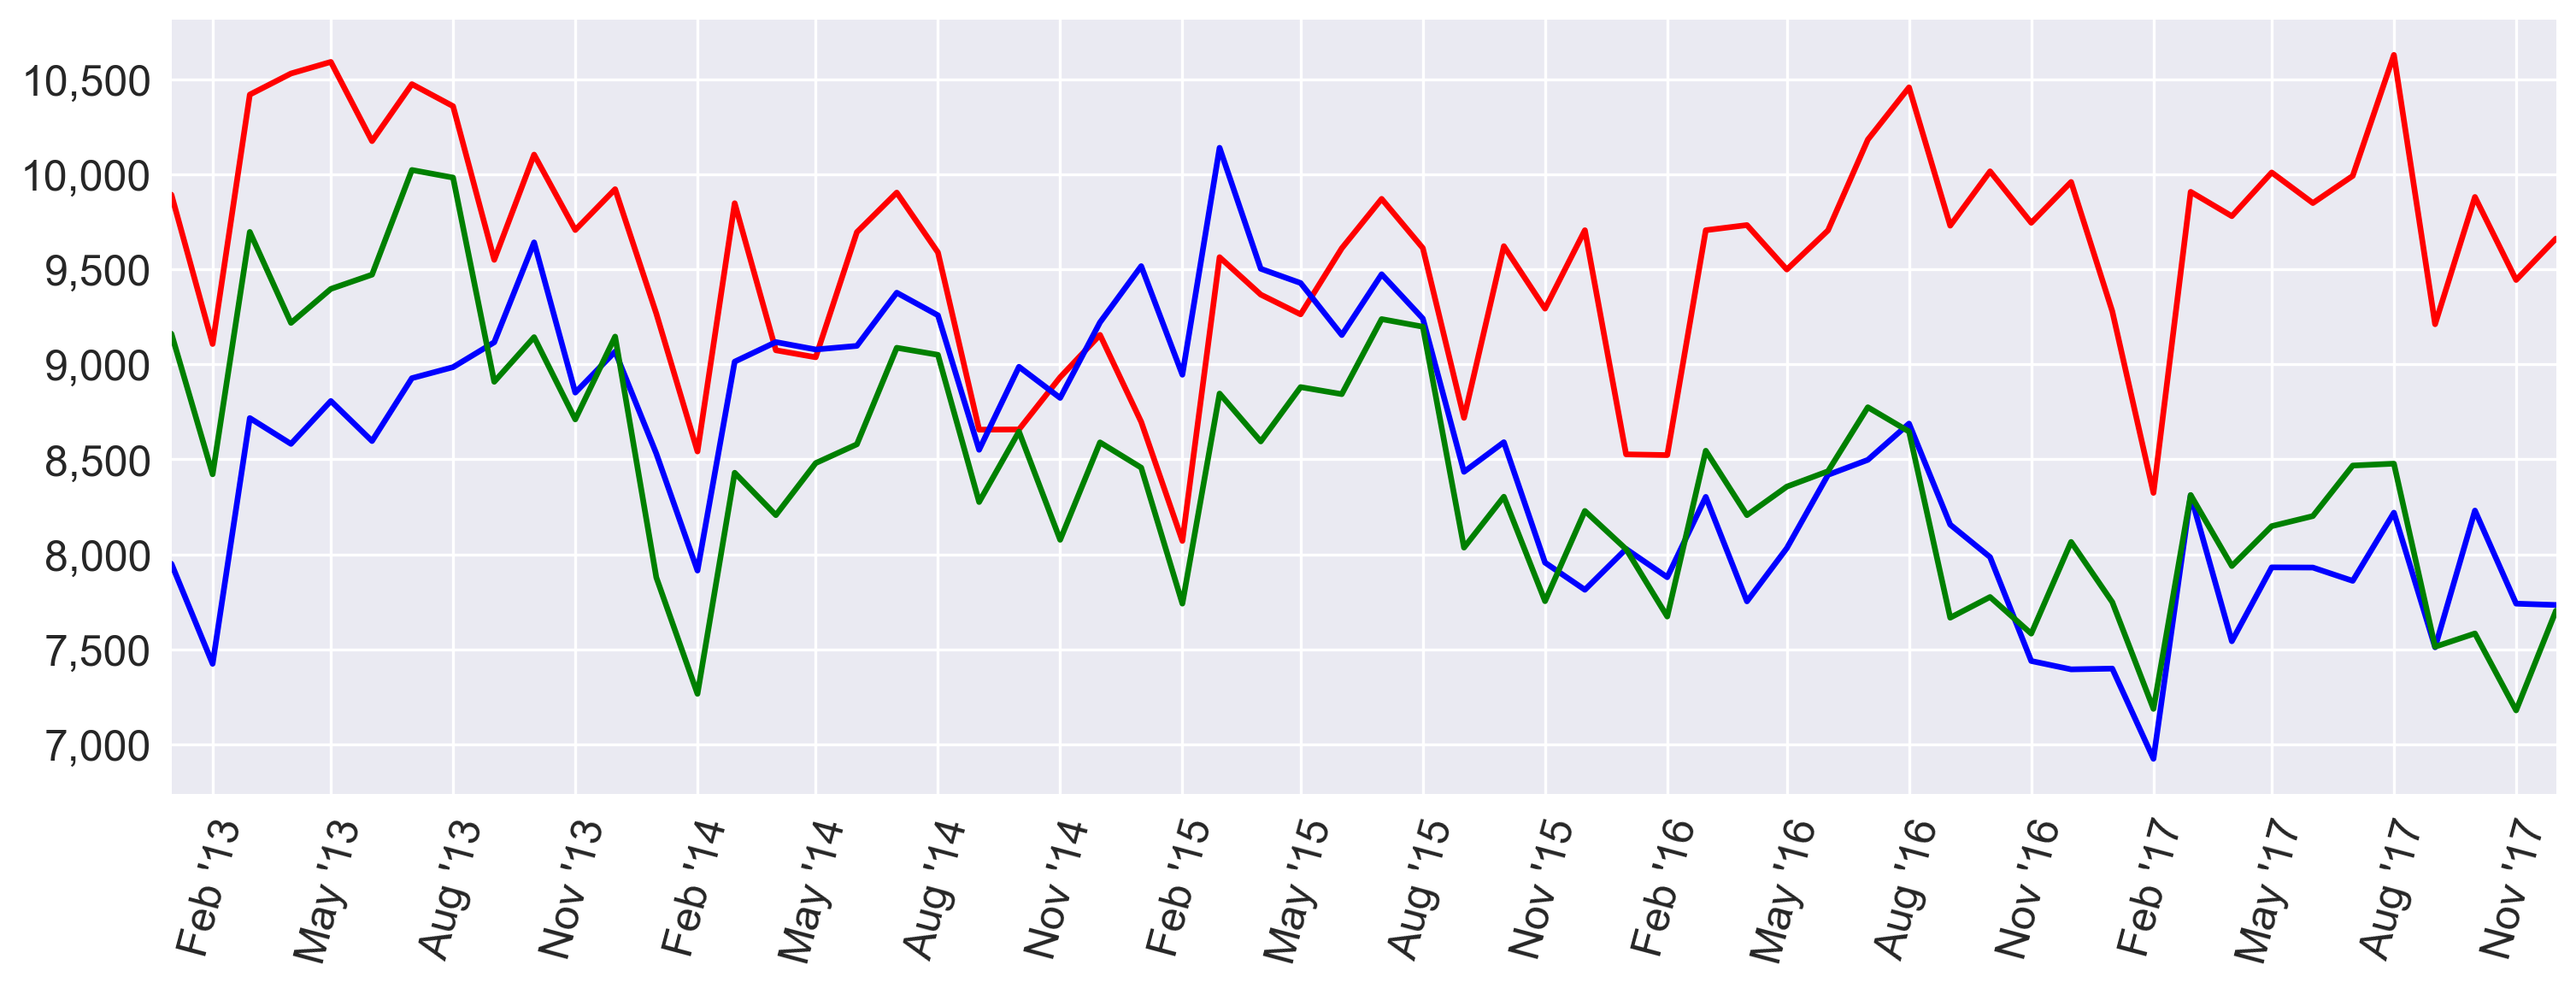

In [4]:
formatter = plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x)))
plot_ny_metro_comparison(ny_metro, y_value='departures', y_formatter=formatter)

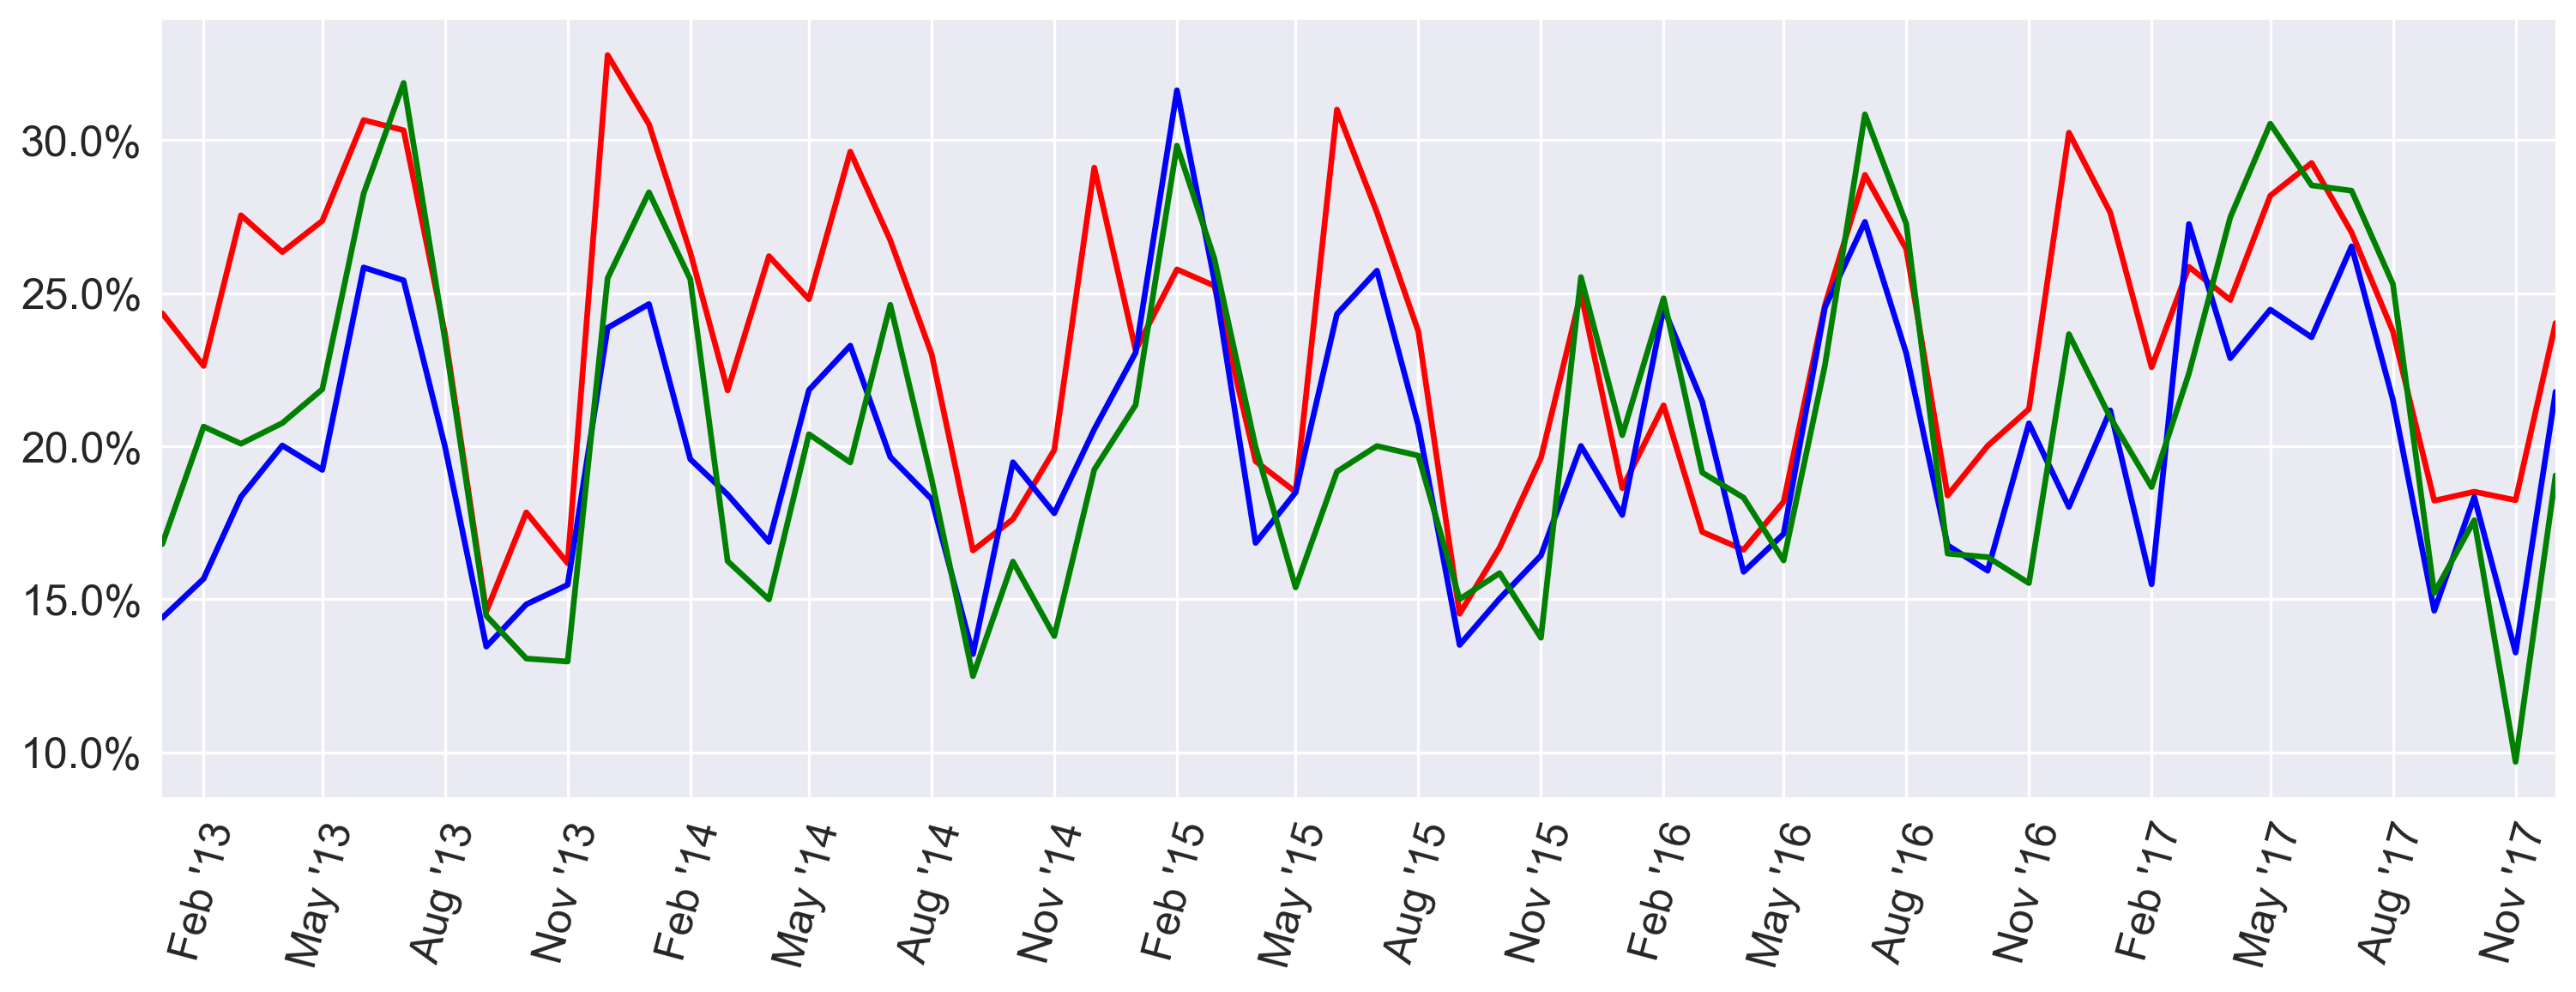

In [5]:
formatter = PercentFormatter(xmax=1)
plot_ny_metro_comparison(ny_metro, y_value='delay_rate', y_formatter=formatter)

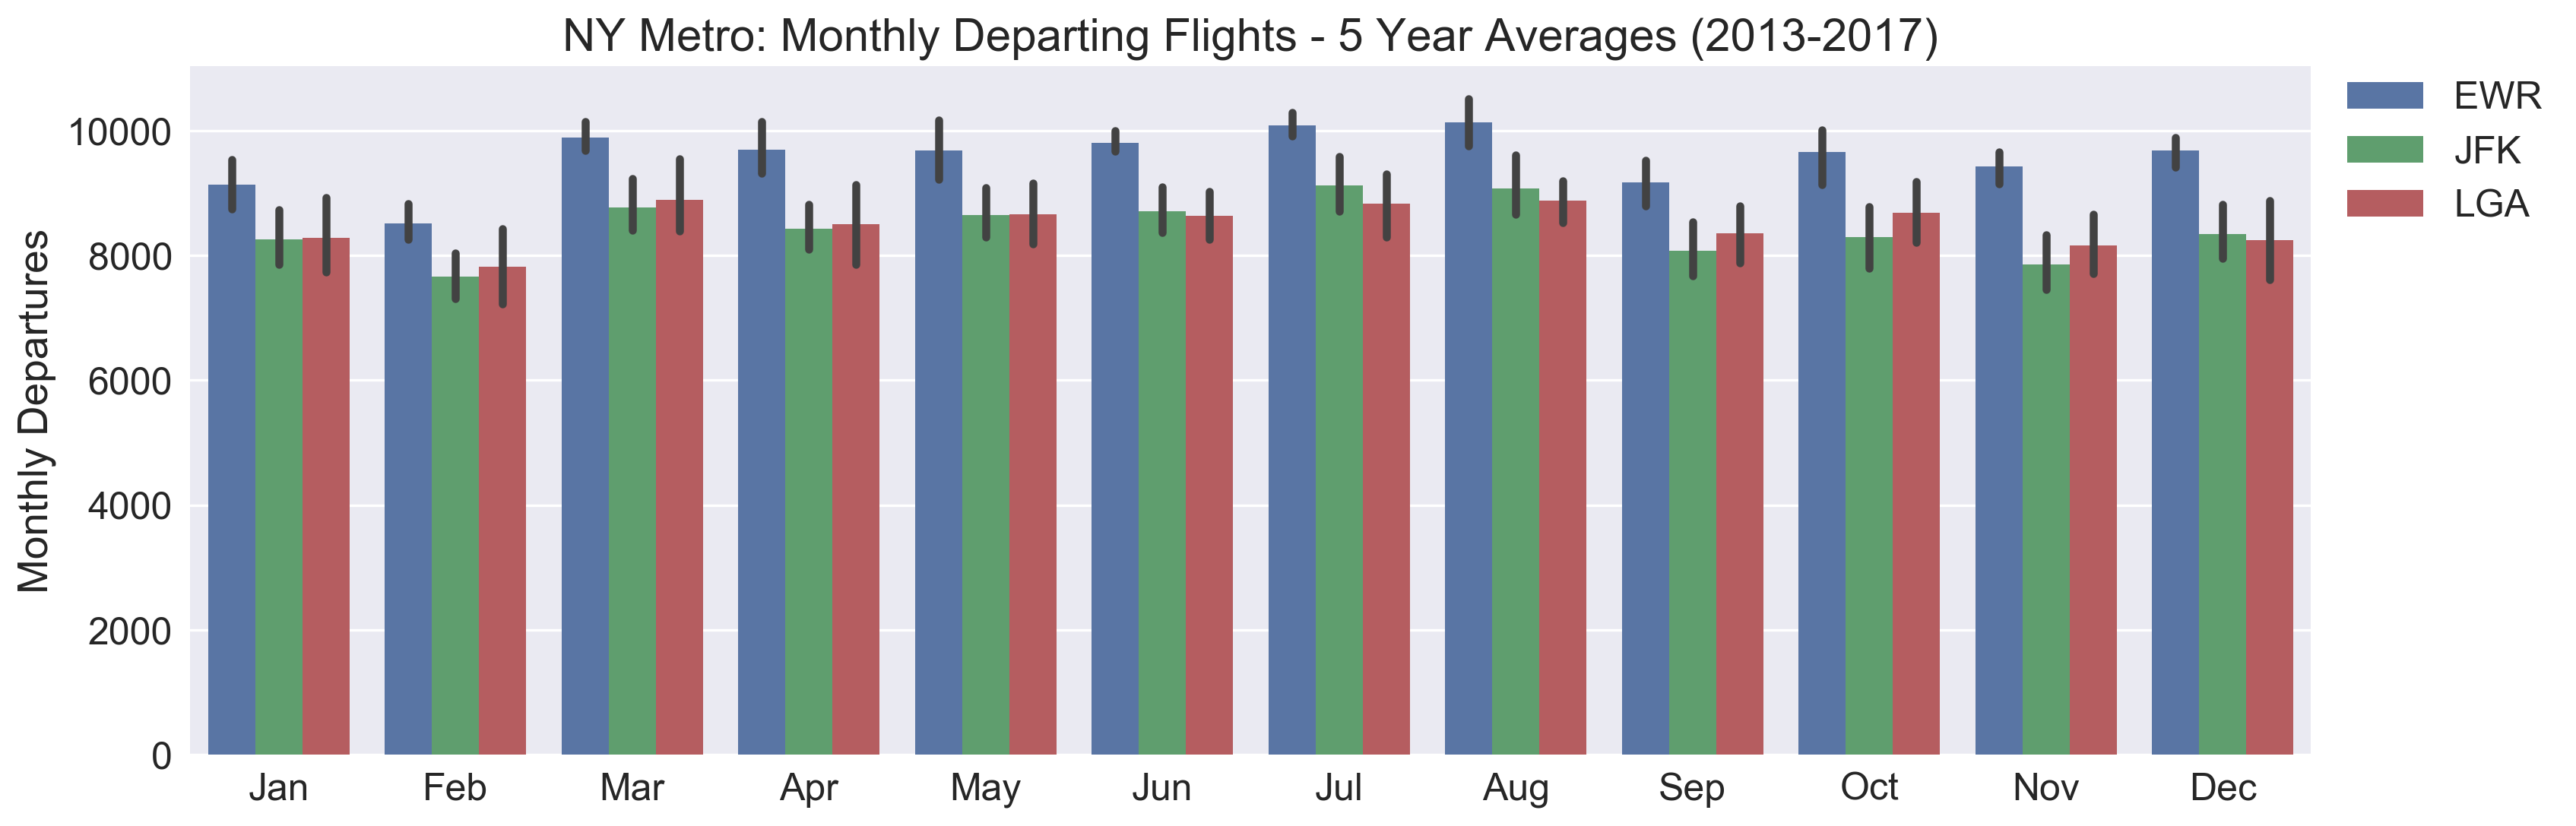

In [6]:
def plot_comparison_by_number_of_monthly_departures(data):
    fig, ax = plt.subplots(figsize=(15, 5), dpi=240)
    sns.barplot(x='month_abbr', y='departures', hue='Airport', data=data, ax=ax)
    _ = plt.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)
    _ = plt.xlabel('')
    _ = plt.ylabel('Monthly Departures')
    _ = plt.title('NY Metro: Monthly Departing Flights - 5 Year Averages (2013-2017)')
    plt.show()

plot_comparison_by_number_of_monthly_departures(ny_metro)

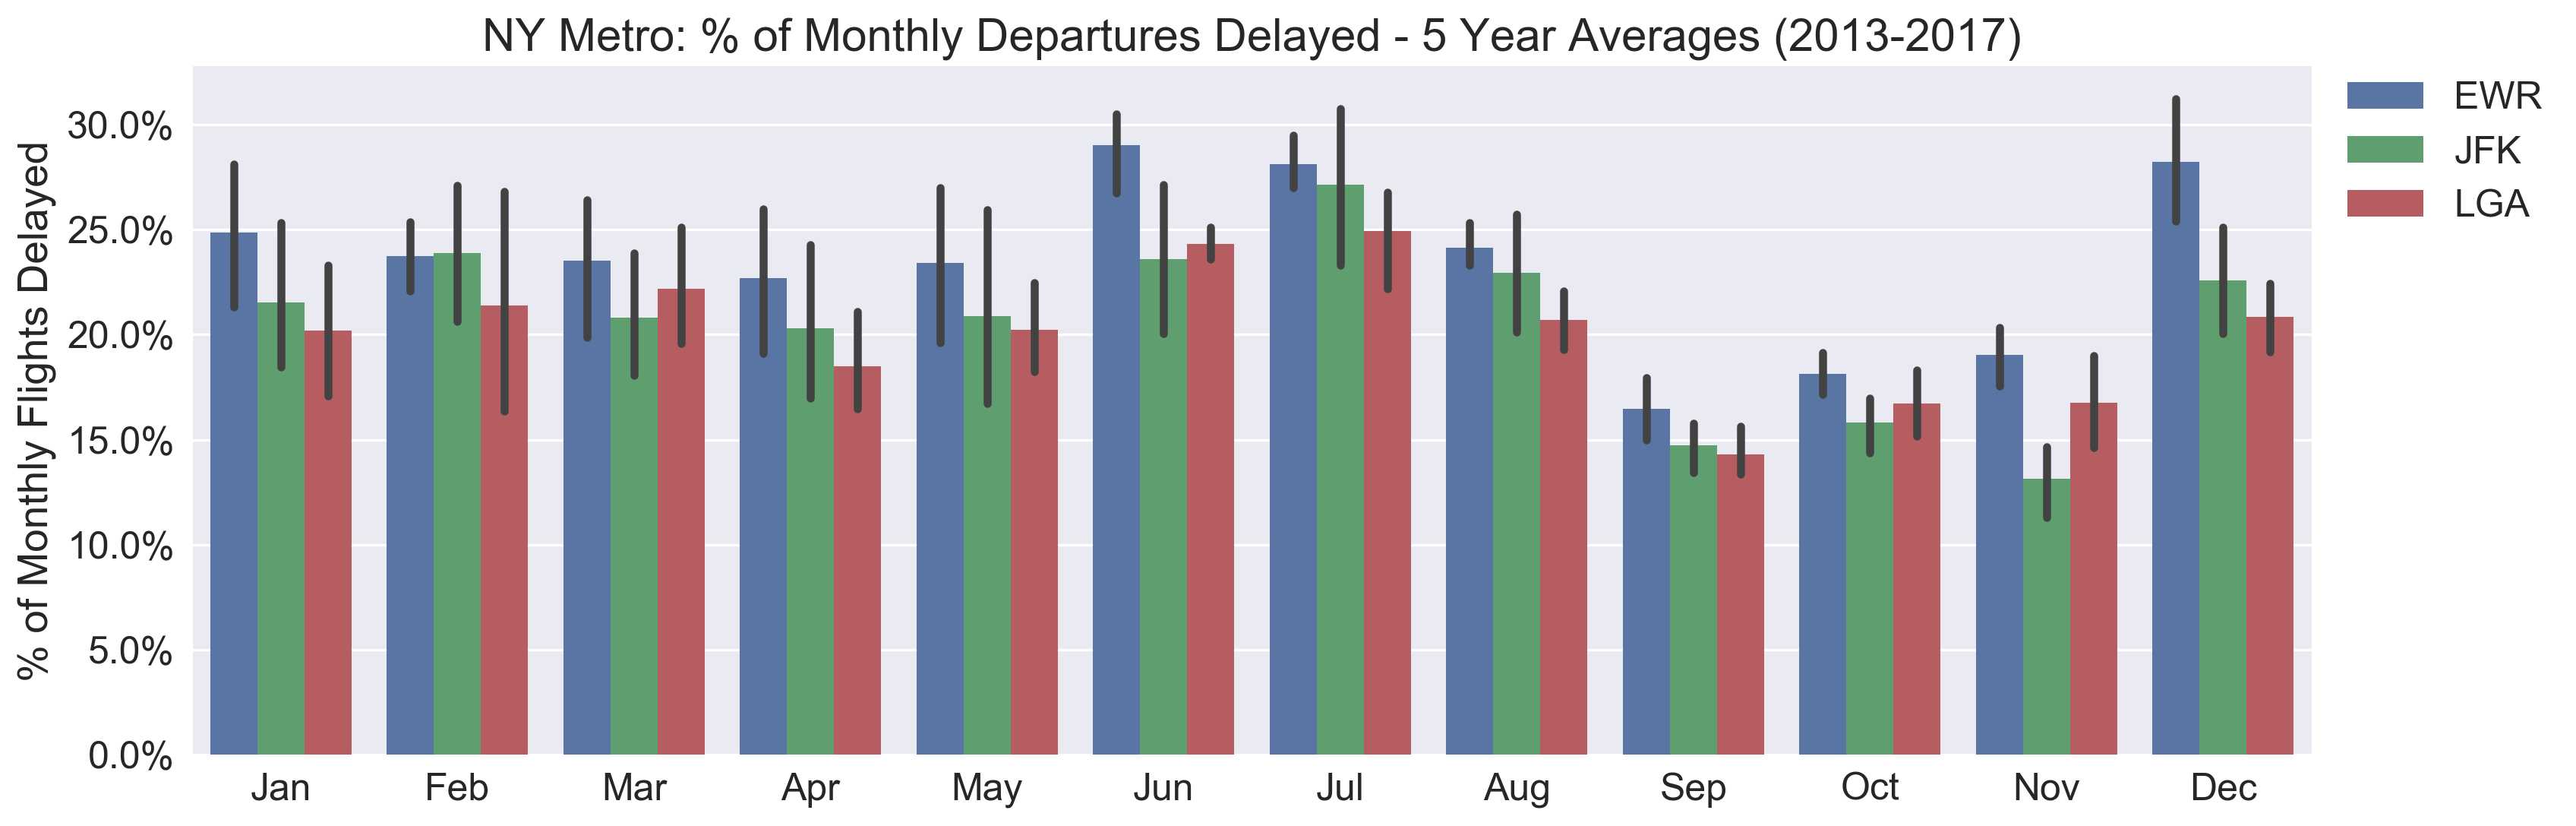

In [7]:
def plot_comparison_by_percent_of_flights_delayed(data):
    fig, ax = plt.subplots(figsize=(15, 5), dpi=240)
    sns.barplot(x='month_abbr', y='delay_rate', hue='Airport', data=data, ax=ax)
    _ = plt.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)
    _ = ax.get_yaxis().set_major_formatter(PercentFormatter(xmax=1))
    _ = plt.xlabel('')
    _ = plt.ylabel('% of Monthly Flights Delayed')
    _ = plt.title('NY Metro: % of Monthly Departures Delayed - 5 Year Averages (2013-2017)')
    _ = plt.savefig("../../reports/figures/new-york-metro-rates-of-delay.png", bbox_inches='tight')
    plt.show()
    
plot_comparison_by_percent_of_flights_delayed(ny_metro)